<a href="https://colab.research.google.com/github/tartieres/movies/blob/master/Deep2_TP_DL2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>TP2 Deep Learning - CNN</h1>

Cette troisième séance porte sur la découverte des réseaux de convolutions :
* Retour sur MNIST
* Première architecture convolutionnelle
* Visualisation des filtres
* Utilisation de VGG16, un réseau pré-entrainé
* Visualisation des filtres par maximisation des activations
* Augmentation de données
* Classification du jeu de données Cifar10



In [0]:
venv_root = '/amuhome/ayache/deep'    # A modifier !! Utile seulement sur le serveur de Luminy

import sys
sys.path.append(venv_root+'/lib/python3.5/site-packages')

import warnings
warnings.simplefilter("ignore")

Import des premiers packages nécessaires :

In [0]:
import numpy as np
import keras
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
print(keras.__version__)

Using TensorFlow backend.


2.2.5


<h2> Chargement des données</h2>

Ici on charge le jeu de données MNIST (les chiffres manuscrits), puis quelques instructions de mise en forme

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows, img_cols = 28, 28
num_classes = 10
nb_samples = len(x_train)
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

11493376/11490434 [==============================] - 2s 0us/step


Le jeu de données MNIST contient 60000 exemples répartis en 10 classes. Nous allons ici en sélectionner aléatoirement un certain nombre pour accélérer les étapes suivantes.

In [0]:
l_idx = list(range(nb_samples))
np.random.shuffle(l_idx) 
l_idx = l_idx[:10000]

x_train, y_train = x_train[l_idx], y_train[l_idx]

Il est d'abord nécessaire de formater les vecteurs d'étiquettes en <i>one-hot vectors</i> de tailles num_classes. Ces vecteurs contiennent des 0 et un seul 1 par ligne à l'indice correspondant à la classe

In [0]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape)

(10000, 28, 28, 1)


<h3> Réseau "Dense"</h3>

Reprenons le réseau considéré à la fin du premier TP. Notez son nombre de paramètres et sa performance obtenue, ils nous serviront de référence.

In [0]:
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

loss = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_split=0.1, callbacks=[], verbose=1)

score = model.evaluate(x_test, y_test, verbose=0)
print("score=", score)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                10250     

<h3>Première architecture convolutionnelle</h3>

Créons un nouveau réseau dont les couches Dense (sauf la dernière pour la classification) sont remplacées par des Conv2D, suivis de MaxPooling2D. Notons que la couche "Flatten" n'est pas utilisée en début de réseau, puisque les données du réseau sont supposées 2D. En revanche, la couche Dense en bout de réseau suppose des données d'entrée en 1D.


In [0]:
model2 = Sequential()
model2.add(Conv2D(64, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', input_shape=input_shape))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model2.add(MaxPooling2D((2,2)))
model2.add(Flatten())
model2.add(Dropout(0.2))
model2.add(Dense(num_classes, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model2.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)            

<b>A faire :</b> Expliquez les nombres de paramètres de chaque couche

<h4>Entrainement du réseau :</h4>

Appelons maintenant les fonctions fit et evaluate pour entrainer et tester le réseau. Visualisez la courbe d'apprentissage pour vérifier que tout s'apprend bien.

In [0]:
loss = model2.fit(x_train, y_train, batch_size=128, epochs=20, validation_split=0.1, callbacks=[], verbose=1)

score = model2.evaluate(x_test, y_test, verbose=0)
print("score=", score)

Train on 9000 samples, validate on 1000 samples
Epoch 1/20
9000/9000 [==============================] - 4s 473us/step - loss: 0.7445 - acc: 0.7672 - val_loss: 0.1809 - val_acc: 0.9400
Epoch 2/20
9000/9000 [==============================] - 1s 161us/step - loss: 0.1471 - acc: 0.9542 - val_loss: 0.1521 - val_acc: 0.9540
Epoch 3/20
9000/9000 [==============================] - 1s 163us/step - loss: 0.1001 - acc: 0.9669 - val_loss: 0.1034 - val_acc: 0.9660
Epoch 4/20
9000/9000 [==============================] - 1s 162us/step - loss: 0.0738 - acc: 0.9761 - val_loss: 0.0904 - val_acc: 0.9750
Epoch 5/20
9000/9000 [==============================] - 1s 161us/step - loss: 0.0568 - acc: 0.9803 - val_loss: 0.0954 - val_acc: 0.9680
Epoch 6/20
9000/9000 [==============================] - 1s 162us/step - loss: 0.0437 - acc: 0.9839 - val_loss: 0.0908 - val_acc: 0.9720
Epoch 7/20
9000/9000 [==============================] - 1s 160us/step - loss: 0.0364 - acc: 0.9868 - val_loss: 0.0880 - val_acc: 0.9740


<h4>Visualisation des cartes</h4>

Une carte "réponse" (ou feature map) d'une couche de convolution correspond à l'état des activations en sortie d'une telle couche. Leur contenu dépend donc d'une image passée en entrée du réseau. 

Une couche définie pour apprendre 64 filtres de convolution, génère ainsi 64 cartes. On définie d'abord une fonction pour l'affichage d'un tableau d'images (via matplotlib)

In [0]:
import matplotlib.pyplot as plt
def show_images(images, cols = 1):
    
    n_images = len(images)
    fig = plt.figure()
    for n, image in enumerate(images):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.axis('off')
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        

Une manière simple pour obtenir ces cartes, via l'API Keras, consiste à faire passer une image (au choix mais de la bonne taille) à travers un réseau tronqué à la couche dont on veut visualiser les sorties.

0.0 1.001195 (1, 28, 28, 64)


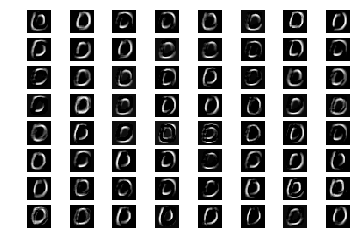

In [0]:
from keras.models import Model

# Définition d'un modèle via la "graph" API de Keras
model_tmp = Model(model2.layers[0].input, model2.layers[0].output)

# Cartes réponses de x_test[10] (un '0')
feature_maps = model_tmp.predict(np.expand_dims(x_test[10], 0))

# normalisation des valeurs entre 0 et 1
minimum, maximum = np.min(feature_maps), np.max(feature_maps)
feature_maps = (feature_maps - minimum) / (maximum - minimum)

print(minimum, maximum, feature_maps.shape)

from PIL import Image
from IPython.display import display

images = []
for i in range(64):
  images.append(np.array(255*feature_maps[:,:,:,i]).reshape(28,28).astype('uint8'))

show_images(images, 8)

Les images obtenues semblent montrer que les filtres appris dans la première couche du réseau permettent la détection d'orientations ou des contours. 



<h4>Visualisation des filtres</h4>

La visualisation des filtres de la couche d'entrée est relativement immédiate puisque que les filtres ont le même nombre de channels que les données d'entrée. Autrement dit, les filtres de la première couche sont définis sur le même domaine que les données.


In [0]:
# Récupère tous les paramètres appris par le réseau
weights = model2.get_weights()

for w in weights: print(w.shape)

(5, 5, 1, 64)
(64,)
(3, 3, 64, 128)
(128,)
(3, 3, 128, 128)
(128,)
(1152, 10)
(10,)


<b>A faire : </b> A quoi correspondent chaque ligne issues de l'affichage de la cellule précédente ?

Affichons maintenant les filtres de la première couche de convolution :

-0.21531983 0.15062647


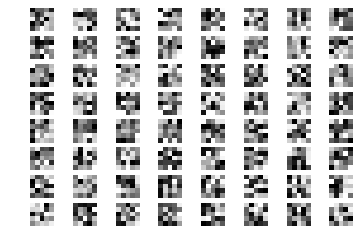

In [0]:
# normalize values between 0 and 1
minimum, maximum = np.min(weights[0]), np.max(weights[0])
weights0 = (weights[0] - minimum) / (maximum - minimum)

print(minimum, maximum)
# entre 0 et 255 pour l'affichage
weights0 *= 255.

images = []
for i in range(64):
  images.append(np.array(255*weights0[:,:,:,i]).reshape(5,5).astype('uint8'))

show_images(images, 8)

<h3> CNN pour des images naturelles </h3>

Les filtres de convolutions appris sur les données MNIST ne sont pas très parlantes, intéressons nous plutôt à un réseau (beaucoup plus profond) adapté à la classification d'images naturelles. Nous allons considérer pour cela le réseau VGG16, pré-entrainé sur le dataset ImageNet (cf cours).

In [0]:
!wget https://pageperso.lis-lab.fr/stephane.ayache/cat.jpg
!wget https://pageperso.lis-lab.fr/stephane.ayache/imagenet_class_index.json 

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import json

# Récupération du modèle complet VGG16
model3 = VGG16(include_top=True, weights='imagenet')
#print(model3.summary())

# chargement d'un dictionnaire qui met en correspondant l'index d'une classe ImageNet et son nom
with open('imagenet_class_index.json') as f:
    CLASS_INDEX = json.load(f)

# chargement et preprocess de l'image (dont normalisation et redimensionnement)
img_path = 'cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# prédiction et affichage de la classe de probabilité maximale
softmax_output = model3.predict(x)
best_class = np.argmax(softmax_output)
im_class = CLASS_INDEX[str(best_class)][1]
print("prediction: ", im_class)

--2019-09-30 06:35:23--  https://pageperso.lis-lab.fr/stephane.ayache/cat.jpg
Resolving pageperso.lis-lab.fr (pageperso.lis-lab.fr)... 139.124.22.27
Connecting to pageperso.lis-lab.fr (pageperso.lis-lab.fr)|139.124.22.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86130 (84K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>]  84.11K   159KB/s    in 0.5s    

2019-09-30 06:35:26 (159 KB/s) - ‘cat.jpg’ saved [86130/86130]

--2019-09-30 06:35:27--  https://pageperso.lis-lab.fr/stephane.ayache/imagenet_class_index.json
Resolving pageperso.lis-lab.fr (pageperso.lis-lab.fr)... 139.124.22.27
Connecting to pageperso.lis-lab.fr (pageperso.lis-lab.fr)|139.124.22.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/json]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K   130KB/s    in 0.3s    

2019-09-30 06:35:28 (130 KB/s) - ‘imagenet_class

Notre chaton a été reconnu comme un chat ? Alors tout va bien, et regardons les filtres de la première couche ...

-0.67140007 0.6085159


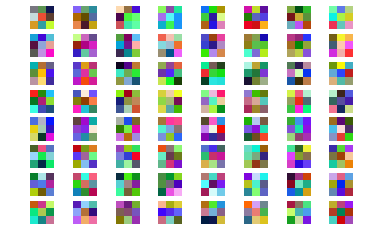

In [0]:
weights = model3.get_weights()
#for w in weights: print(w.shape)
  
# normalize values between 0 and 1
minimum, maximum = np.min(weights[0]), np.max(weights[0])
weights0 = (weights[0] - minimum) / (maximum - minimum)

print(minimum, maximum)
# entre 0 et 255 pour l'affichage
weights0 *= 255.

images = []
for i in range(64):
  images.append(np.array(255*weights0[:,:,:,i]).reshape(3,3,3).astype('uint8'))

show_images(images, 8)

Notez qu'on affiche ici les fltres en RGB alors qu'on pourrait les afficher en séparant les channels. Dans tous les cas, cette visualisation reste peu informative, pour mieux comprendre le rôle d'une couche de convolution, d'autres méthodes sont plus efficaces (cf cours précédent). Ci dessous, nous allons générer une image qui maximise la valeur d'une carte d'activation (réponse à un filtre).

<h3> Visualisation par maximisation d'activations</h3>
  
Les fonctions Tensorflow du backend Keras nous permettent de définir une fonction d'une image vers les activations d'une carte d'une couche de convolution. Maximiser cette fonction en suivant le gradient de la sortie par rapport aux entrées, revient à déterminer une image (artificielle) dont VGG16 obtient une forte réponse à la convolution du filtre ciblé. L'image produite va être composée du "pattern" reconnu par le filtre...

D'abord, quelques fonctions utiles :

In [0]:
def deprocess_image(x):
# normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    
    return x * 255.

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())
  

print(model3.summary())


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Définition d'une fonction en Keras ; obtention du gradient ; gradient ascent pour maximiser ; 

Current loss value: 0.0
(1, 224, 224, 3)


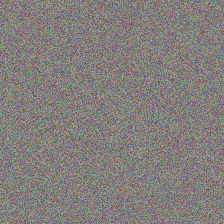

In [0]:
from keras import backend as K

num_filter = 208

# entrée de la fonction à maximiser = entrée du réseau VGG = une image
input_img = model3.layers[0].input

# sortie = Somme (moyenne) des activations d'une carte de convolution associée au filtre num_filter
output = K.mean(model3.layers[17].output[:, :, :, num_filter])

# returns the gradients of output w.r.t. input
grads = K.gradients(output, input_img)[0]
grads = normalize(grads)

# fonction : input -> output, gradients 
func = K.function([input_img], [output, grads])

## gradient ascent ##

# point de départ aléatoire
x = np.random.random((1, 224, 224, 3)) * 255.
x = preprocess_input(x)

for i in range(40): # 40 iterations
    loss_value, grads_value = func([x])
    x += grads_value * 10

    print('Current loss value:', loss_value)
    if loss_value <= 0.:
        # some filters get stuck to 0
        break

# point d'arrivée : conversion en RGB puis affichage
xx = deprocess_image(x)

from PIL import Image
print(xx.shape)
display(Image.fromarray(xx[0].astype('uint8')))


<b> A faire : </b> variez les couches et les filtres, puis commentez vos résultats obtenus. Comment obtenir des motifs encore plus complexes ?

<h2> Entrainement d'un réseau très profond </h2>

Un réseau très profond tel que VGG contient énormément de paramètres, son entrainement peu s'avérer compliquer. Tous les paramètres doivent entrer en mémoire (RAM ou GPU), ainsi que toutes les données d'un minibatch. Dans le cas d'images relativement volumineuses (ie: Imagenet =255x255x3), la taille du minibatch est souvent ainsi très couteux en mémoire et se voit ainsi réduit à quelques images, rendant l'entrainement encore plus long... 

Souvent, de grandes bases de données ne sont pas disponibles. Dans ce cas, pour parvenir à entrainer un tel réseau avec peu d'images, plusieurs options sont possibles :
- partir d'un réseau déjà (pré-)entrainé, et/ou utiliser ses poids pour initialiser un autre réseau qui sera appris sur une base (réduite) d'images (= finetuning, très efficace)
- régulariser les poids du réseau (peut aider mais ne suffit pas)
- augmenter artificiellement le nombre de données (améliore toujours les performances d'un réseau)

Dans la suite, nous illustrons ce dernier point sur les données MNIST.


In [0]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows, img_cols = 28, 28
num_classes = 10
nb_samples = len(x_train)
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Sélection aléatoire de 5000 exemples
l_idx = list(range(nb_samples))
np.random.shuffle(l_idx) 
l_idx = l_idx[:5000]
x_train, y_train = x_train[l_idx], y_train[l_idx]

# conversion des étiquettes au format one-hot vector
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


# Architecture du modèle
model2 = Sequential()
model2.add(Conv2D(64, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', input_shape=input_shape))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model2.add(MaxPooling2D((2,2)))
model2.add(Flatten())
model2.add(Dropout(0.2))
model2.add(Dense(num_classes, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#print(model2.summary())

model2.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1)

score = model2.evaluate(x_test, y_test, verbose=0)
print("score=", score)

Epoch 1/20
5000/5000 [==============================] - 1s 249us/step - loss: 1.1108 - acc: 0.6518
Epoch 2/20
5000/5000 [==============================] - 1s 158us/step - loss: 0.2339 - acc: 0.9258
Epoch 3/20
5000/5000 [==============================] - 1s 157us/step - loss: 0.1427 - acc: 0.9556
Epoch 4/20
5000/5000 [==============================] - 1s 157us/step - loss: 0.1021 - acc: 0.9666
Epoch 5/20
5000/5000 [==============================] - 1s 154us/step - loss: 0.0744 - acc: 0.9772
Epoch 6/20
5000/5000 [==============================] - 1s 157us/step - loss: 0.0642 - acc: 0.9784
Epoch 7/20
5000/5000 [==============================] - 1s 155us/step - loss: 0.0474 - acc: 0.9856
Epoch 8/20
5000/5000 [==============================] - 1s 156us/step - loss: 0.0385 - acc: 0.9882
Epoch 9/20
5000/5000 [==============================] - 1s 156us/step - loss: 0.0328 - acc: 0.9894
Epoch 10/20
5000/5000 [==============================] - 1s 157us/step - loss: 0.0244 - acc: 0.9928
Epoch 11/

La performance obtenue peut être améliorée en augmentant les données. La cellule suivante génère 20000 données à partir des 5000 utilisées jusque là.



(128, 28, 28, 1) (128, 10)
Epoch 1/20
156/156 [==============================] - 7s 48ms/step - loss: 0.5232 - acc: 0.8322
Epoch 2/20
156/156 [==============================] - 7s 45ms/step - loss: 0.1299 - acc: 0.9598
Epoch 3/20
156/156 [==============================] - 7s 46ms/step - loss: 0.0753 - acc: 0.9763
Epoch 4/20
156/156 [==============================] - 7s 46ms/step - loss: 0.0569 - acc: 0.9815
Epoch 5/20
156/156 [==============================] - 7s 48ms/step - loss: 0.0462 - acc: 0.9850
Epoch 6/20
156/156 [==============================] - 7s 48ms/step - loss: 0.0372 - acc: 0.9879
Epoch 7/20
156/156 [==============================] - 7s 47ms/step - loss: 0.0303 - acc: 0.9899
Epoch 8/20
156/156 [==============================] - 7s 47ms/step - loss: 0.0263 - acc: 0.9912
Epoch 9/20
156/156 [==============================] - 7s 48ms/step - loss: 0.0201 - acc: 0.9929
Epoch 10/20
156/156 [==============================] - 8s 48ms/step - loss: 0.0209 - acc: 0.9922
Epoch 11/20


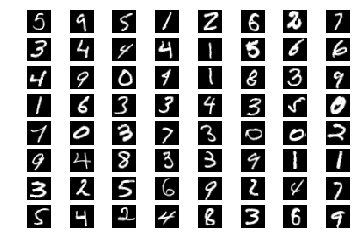

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# déclaration d'un générateur, qui transformera "à la volée" des données MNIST 
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    zoom_range = 0.05, 
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=False, # flip horizontal et vertical n'ont pas de sens pour des digits !
    vertical_flip=False
    )
datagen.fit(x_train)

# On instancie le générateur
flow = datagen.flow(x_train, y_train, batch_size=128, shuffle=True)

# Pour affichage : une itération du générateur
xx = next(flow)
print(xx[0].shape, xx[1].shape)

images = []
for i in range(64):
  images.append(np.array(255*xx[0][i,:,:,:]).reshape(28,28).astype('uint8'))
show_images(images, 8)


# réinitialisation du modèle
model2 = Sequential()
model2.add(Conv2D(64, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', input_shape=input_shape))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model2.add(MaxPooling2D((2,2)))
model2.add(Flatten())
model2.add(Dropout(0.2))
model2.add(Dense(num_classes, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# entrainement avec les données augmentées (à la volée)
model2.fit_generator(datagen.flow(x_train, y_train, batch_size=128), steps_per_epoch=int(20000/128), epochs=20)

# évaluation
score = model2.evaluate(x_test, y_test, verbose=0)
print("score=", score)


<b>A faire : </b> testez d'autres formes d'augmentation et d'autres quantités pour constater l'impact sur la précision du réseau.
<b>A faire : </b> modifiez l'architecture pour la classification d'images naturelles, en utilisant le jeu de données Cifar10.